In [8]:
import numpy as np
import matplotlib.pyplot as plt
from camutils import Camera, calibratePose, triangulate, residuals, triangulate, makerotation
import pickle
import visutils
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay
import scipy.optimize
import trimesh
import cv2
import pickle


%matplotlib inline

# NOTE: 
**I did not give myself enough time to streamline this whole process, as the code is written now, I had to individually 
change all the file names for each set of images, call reconstruct each time manually, then continue the process one step at a time and save each mesh that I generated one by one. This is not how I intented to turn this in but I failed to manage my time with this project.**

In [2]:
plt.rcParams['figure.figsize']=[15,15] #adjust this as needed to get clearly visible figures

In [356]:
def decode(imprefix,start,threshold,x):
    """
    Given a sequence of 20 images of a scene showing projected 10 bit gray code, 
    decode the binary sequence into a decimal value in (0,1023) for each pixel.
    Mark those pixels whose code is likely to be incorrect based on the user 
    provided threshold.  Images are assumed to be named "imageprefixN.png" where
    N is a 2 digit index (e.g., "img00.png,img01.png,img02.png...")
 
    Parameters
    ----------
    imprefix : str
       Image name prefix
      
    start : int
       Starting index
       
    threshold : float
       Threshold to determine if a bit is decodeable
       
    Returns
    -------
    code : 2D numpy.array (dtype=float)
        Array the same size as input images with entries in (0..1023)
        
    mask : 2D numpy.array (dtype=logical)
        Array indicating which pixels were correctly decoded based on the threshold
    
    """
    
    
    thresh = .325
    imprefixColor = imprefix+f'color_C{x}_'
    background = plt.imread(imprefixColor+"00.png")
    foreground = plt.imread(imprefixColor+"01.png")
    if (background.dtype == np.uint8):
        background = background.astype(float) / 256
#     if (len(background.shape)==3):    
#         background = background.mean(axis=-1,keepdims=1)[:,:,0]
    if (foreground.dtype == np.uint8):
        foreground = foreground.astype(float) / 256
#     if (len(foreground.shape)==3):
#         foreground = foreground.mean(axis=-1,keepdims=1)[:,:,0]

    obj = (np.sum(np.abs(foreground-background),axis=-1) > thresh).astype(int)
    
    # we will assume a 10 bit code
    nbits = 10
    # generate list of image files
    images = []
    imprefix = imprefix + f'frame_C{x}_'
    for i in range(20):
        im = imprefix+"0"+str(i) if start+i<10 else imprefix+str(start+i)
        images.append(im+".png")
        
    
    
    gcode = [] # list to contain all of the gray code bits for each pair of images
    for i in range(10):
        im1 = plt.imread(images[2*i])
        im2 = plt.imread(images[2*i+1])

        # don't forget to convert images to grayscale / float after loading them in
        if (im1.dtype == np.uint8):
            im1 = im1.astype(float) / 256
        if (len(im1.shape)==3):    
            im1 = im1.mean(axis=-1,keepdims=1)[:,:,0]
        if (im2.dtype == np.uint8):
            im2 = im2.astype(float) / 256
        if (len(im2.shape)==3):
            im2 = im2.mean(axis=-1,keepdims=1)[:,:,0]
        
        if (i==0):
            H,W = im1.shape
            mask = np.ones((H,W)).astype(int) #create binary mask, intially all True
        gcode.append((im1>im2).astype(int))
        new_mask = np.abs(im1-im2)>=threshold
        mask *= new_mask
    
    bcode = gcode[0].reshape((H,W,1)) # create binary code 3D array
    for i in range(len(gcode)-1):
        bcode = np.dstack((bcode,(np.logical_xor(bcode[:,:,i],gcode[i+1])).astype(int)))
 
    code = []
    for i in range(H):
        for binary in bcode[i]:
            code.append(int(''.join(str(b) for b in binary),2))

    code = np.array(code).reshape((H,W))
    return code,mask,obj

In [361]:
def reconstruct(imprefixL,imprefixR,threshold,camL,camR):
    """
    Performing matching and triangulation of points on the surface using structured
    illumination. This function decodes the binary graycode patterns, matches 
    pixels with corresponding codes, and triangulates the result.
    
    The returned arrays include 2D and 3D coordinates of only those pixels which
    were triangulated where pts3[:,i] is the 3D coordinte produced by triangulating
    pts2L[:,i] and pts2R[:,i]

    Parameters
    ----------
    imprefixL, imprefixR : str
        Image prefixes for the coded images from the left and right camera
        
    threshold : float
        Threshold to determine if a bit is decodeable
   
    camL,camR : Camera
        Calibration info for the left and right cameras
        
    Returns
    -------
    pts2L,pts2R : 2D numpy.array (dtype=float)
        The 2D pixel coordinates of the matched pixels in the left and right
        image stored in arrays of shape 2xN
        
    pts3 : 2D numpy.array (dtype=float)
        Triangulated 3D coordinates stored in an array of shape 3xN
        
    """

    # Decode the H and V coordinates for the two views
    HL,HmaskL,objL = decode(imprefixL,0,threshold,0)
    VL,VmaskL,_ = decode(imprefixL,20,threshold,0)
    HR,HmaskR,objR = decode(imprefixR,0,threshold,1)
    VR,VmaskR,_ = decode(imprefixR,20,threshold,1)
    
    # Construct the combined 20 bit code C = H + 1024*V and mask for each view
    CL = HL + 1024*VL
    maskL = HmaskL*VmaskL*objL
    CR = HR + 1024*VR
    maskR = HmaskR*VmaskR*objR
    
    # Find the indices of pixels in the left and right code image that 
    # have matching codes. If there are multiple matches, just
    # choose one arbitrarily.
    LRvalues, matchL, matchR = np.intersect1d(CL*maskL, CR*maskR, return_indices=True)
    
    # Let CL and CR be the flattened arrays of codes for the left and right view
    # Suppose you have computed arrays of indices matchL and matchR so that 
    # CL[matchL[i]] == CR[matchR[i]] for all i.  The code below gives one approach
    # to generating the corresponding pixel coordinates for the matched pixels.
    h,w = CL.shape
    
    xx,yy = np.meshgrid(range(w),range(h))
    xx = np.reshape(xx,(-1,1))
    yy = np.reshape(yy,(-1,1))
    pts2R = np.concatenate((xx[matchR].T,yy[matchR].T),axis=0)
    pts2L = np.concatenate((xx[matchL].T,yy[matchL].T),axis=0)

    # Now triangulate the points
    pts3 = triangulate(pts2L,camL,pts2R,camR)
    
    
    return pts2L,pts2R,pts3

Camera : 
 f=1404.6009661788062 
 c=[[962.16736916 590.91595682]] 
 R=[[-0.00259871  0.99096865  0.13406854]
 [ 0.99277875 -0.01352251  0.1191952 ]
 [ 0.11993165  0.13341015 -0.98377748]] 
 t = [[ 7.50010665  7.20926303 47.76495312]]
Camera : 
 f=1404.6009661788062 
 c=[[962.16736916 590.91595682]] 
 R=[[ 0.03843674  0.98947412  0.13951197]
 [ 0.9773577  -0.00815434 -0.21143659]
 [-0.2080734   0.14448003 -0.96738357]] 
 t = [[ 6.86588621 19.52347137 47.34419123]]


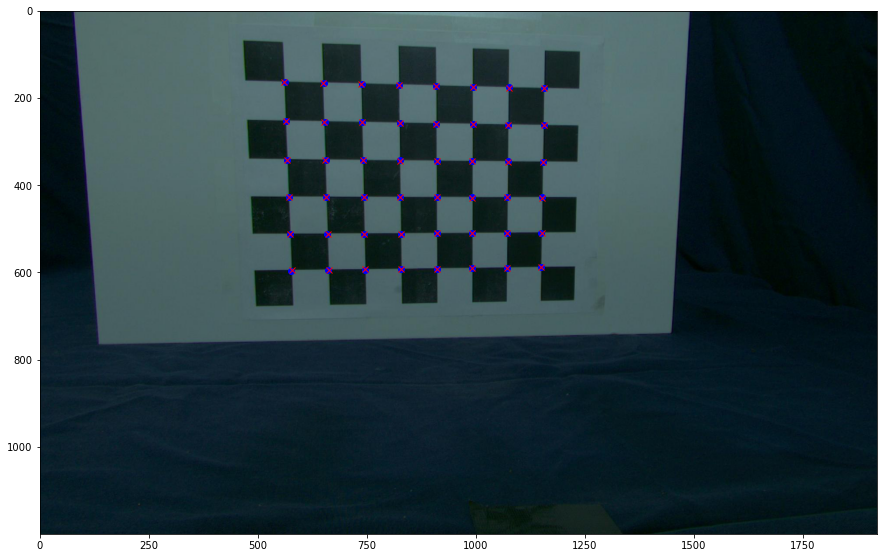

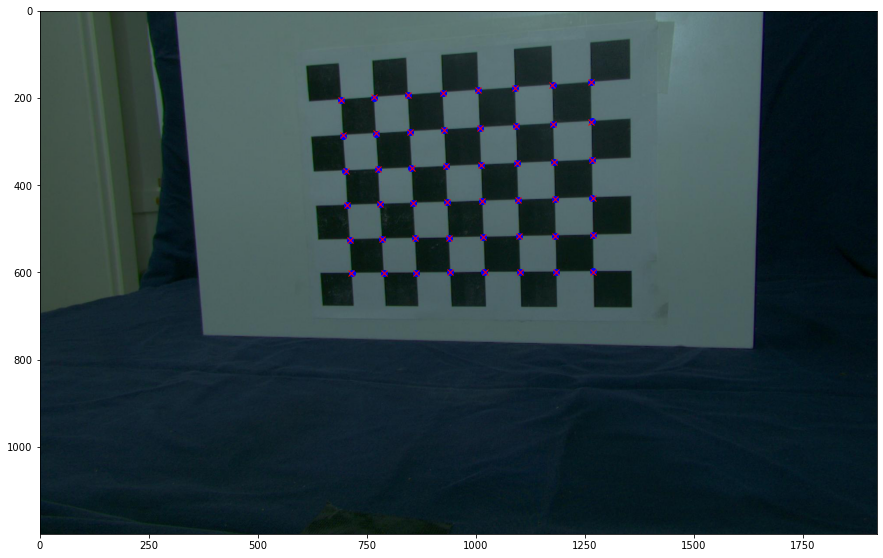

In [465]:
# load in the intrinsic camera parameters from 'calibration.pickle'
fid = open('calibration.pickle','rb')
calib = pickle.load(fid)
fid.close()

f = (calib["fx"]+calib["fy"])/2
# create Camera objects representing the left and right cameras
# use the known intrinsic parameters you loaded in.
camL = Camera(f,np.array([[calib["cx"],calib["cy"]]]).T,np.array([[0,0,0]]).T,makerotation(0,0,0))
camR = Camera(f,np.array([[calib["cx"],calib["cy"]]]).T,np.array([[0,0,0]]).T,makerotation(0,0,0))

# load in the left and right images and find the coordinates of
# the chessboard corners using OpenCV
imgL = plt.imread('data/calib_jpg_u/frame_C1_01.jpg')
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread('data/calib_jpg_u/frame_C0_01.jpg')
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)


# Now use your calibratePose function to get the extrinsic parameters
# for the two images. You may need to experiment with the initialization
# in order to get a good result

paramsL = np.array([0,0,0,0,0,-2])
paramsR = np.array([0,0,0,0,0,-2])
camL.update_extrinsics(paramsL)
camR.update_extrinsics(paramsR)

camL = calibratePose(pts3,pts2L,camL,paramsL)
camR = calibratePose(pts3,pts2R,camR,paramsR)

print(camL)
print(camR)

# As a final test, triangulate the corners of the checkerboard to get back there 3D locations
pts3r = triangulate(pts2L,camL,pts2R,camR)

# Display the reprojected points overlayed on the images to make 
# sure they line up
plt.rcParams['figure.figsize']=[15,15]
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()

pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')
plt.show()


Text(0, 0.5, 'y')

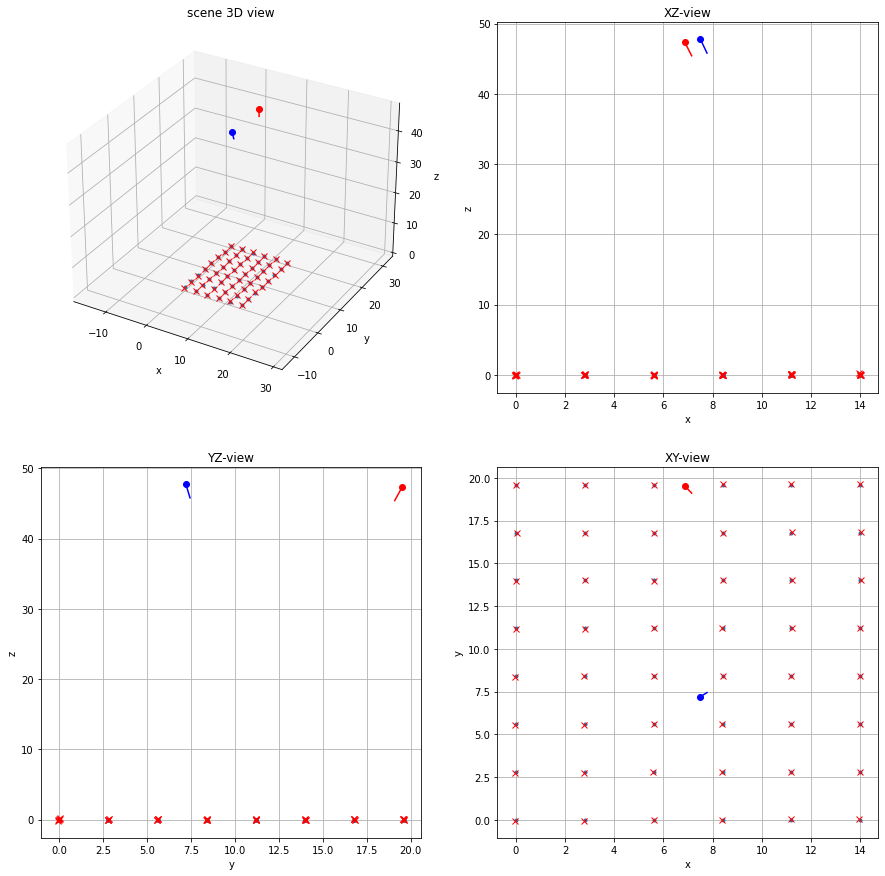

In [466]:
lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,2]]).T))
lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,2]]).T))

# visualize the left and right image overlaid
fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(pts3r[0,:],pts3r[1,:],pts3r[2,:],'rx')
ax.plot(camR.t[0],camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[1],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('scene 3D view')

ax = fig.add_subplot(2,2,2)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(pts3r[0,:],pts3r[2,:],'rx')
ax.plot(camR.t[0],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[2,:],'r')
plt.title('XZ-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')

ax = fig.add_subplot(2,2,3)
ax.plot(pts3[1,:],pts3[2,:],'.')
ax.plot(pts3r[1,:],pts3r[2,:],'rx')
ax.plot(camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[1],camL.t[2],'bo')
ax.plot(lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[1,:],lookR[2,:],'r')
plt.title('YZ-view')
plt.grid()
plt.xlabel('y')
plt.ylabel('z')

ax = fig.add_subplot(2,2,4)
ax.plot(pts3[0,:],pts3[1,:],'.')
ax.plot(pts3r[0,:],pts3r[1,:],'rx')
ax.plot(camR.t[0],camR.t[1],'ro')
ax.plot(camL.t[0],camL.t[1],'bo')
ax.plot(lookL[0,:],lookL[1,:],'b')
ax.plot(lookR[0,:],lookR[1,:],'r')
plt.title('XY-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

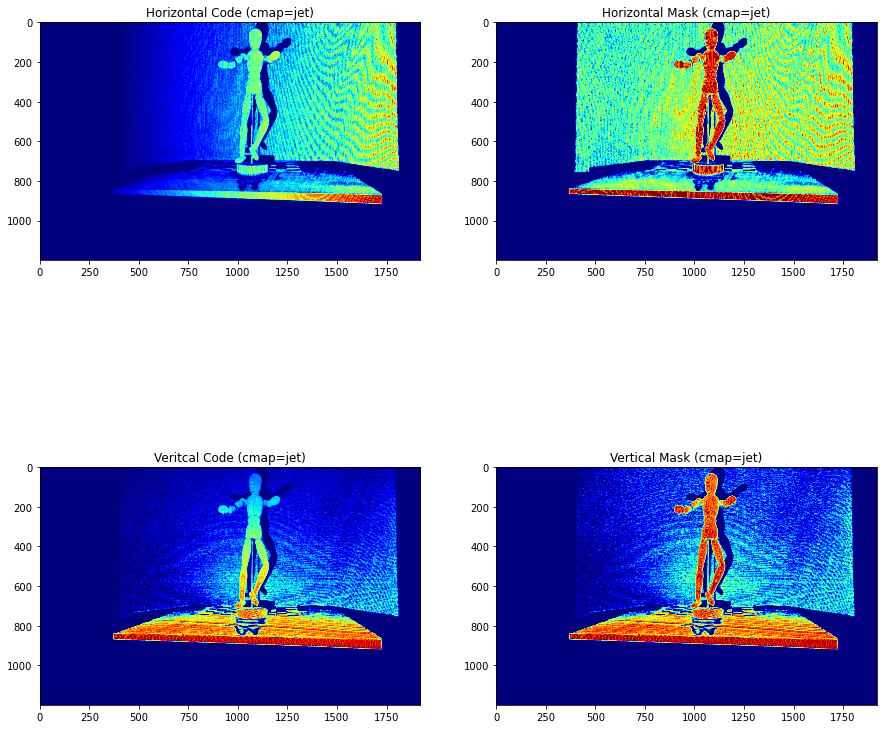

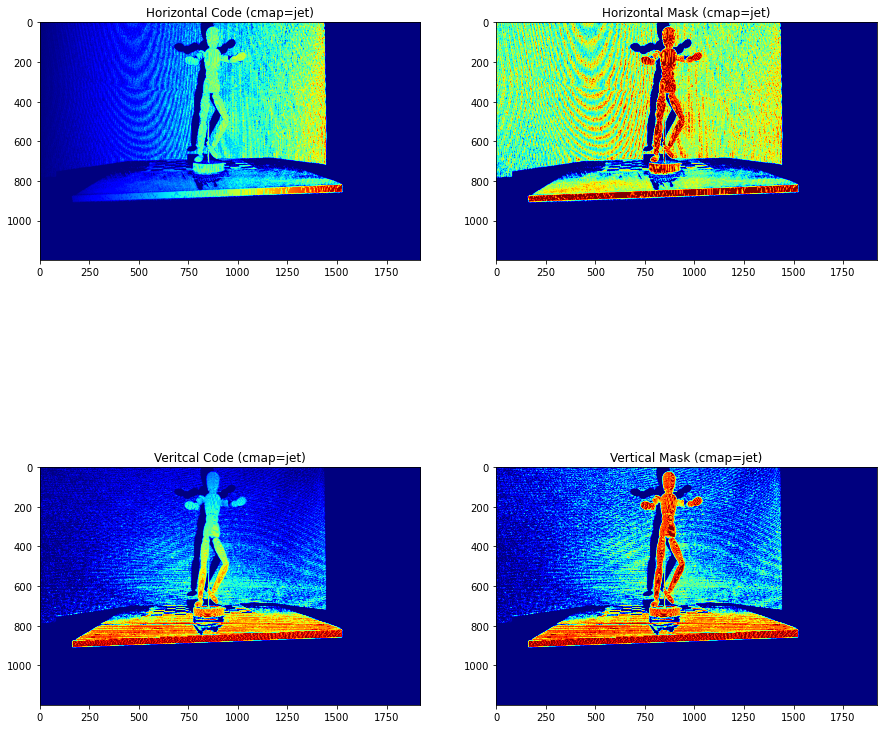

In [359]:
thresh = 0.02
codeH,maskH,objH = decode('/Users/erick/Documents/School/CS 117/FinalAssignment/data/manny/grab_0_u/',0,thresh,0)
codeV,maskV,objV = decode('/Users/erick/Documents/School/CS 117/FinalAssignment/data/manny/grab_0_u/',20,thresh,0)

# display view code and mask as images
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(codeH*maskH,cmap='jet')
ax[0,1].imshow(maskH,cmap='jet')
ax[1,0].imshow(codeV*maskV,cmap='jet')
ax[1,1].imshow(maskV,cmap='jet')
ax[0,0].set_title('Horizontal Code (cmap=jet)')
ax[0,1].set_title('Horizontal Mask (cmap=jet)')
ax[1,0].set_title('Veritcal Code (cmap=jet)')
ax[1,1].set_title('Vertical Mask (cmap=jet)')
plt.show()

thresh = 0.02
codeH,maskH,objH = decode('/Users/erick/Documents/School/CS 117/FinalAssignment/data/manny/grab_0_u/',0,thresh,1)
codeV,maskV,objV = decode('/Users/erick/Documents/School/CS 117/FinalAssignment/data/manny/grab_0_u/',20,thresh,1)

# diusplay view code and mask as images
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(codeH*maskH,cmap='jet')
ax[0,1].imshow(maskH,cmap='jet')
ax[1,0].imshow(codeV*maskV,cmap='jet')
ax[1,1].imshow(maskV,cmap='jet')
ax[0,0].set_title('Horizontal Code (cmap=jet)')
ax[0,1].set_title('Horizontal Mask (cmap=jet)')
ax[1,0].set_title('Veritcal Code (cmap=jet)')
ax[1,1].set_title('Vertical Mask (cmap=jet)')
plt.show()

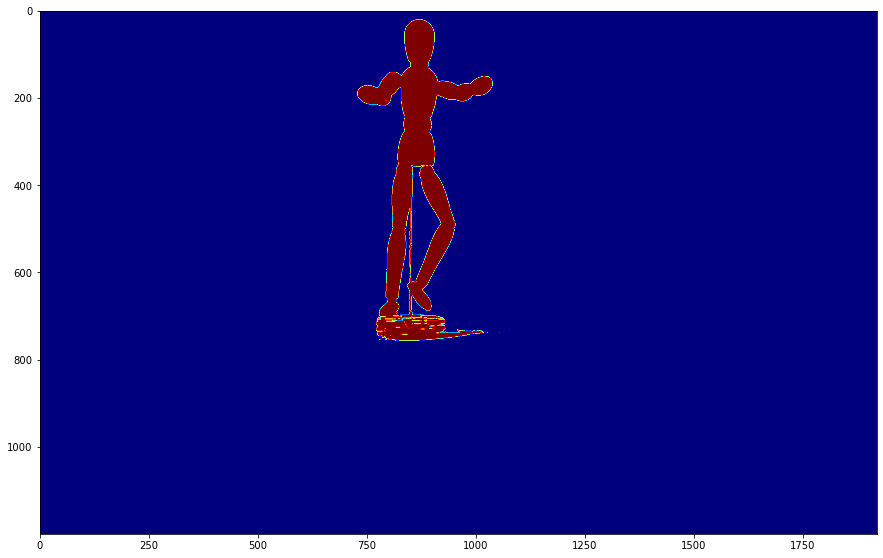

In [360]:
plt.imshow(objH,cmap='jet')

In [451]:
imprefixC0 = '/Users/erick/Documents/School/CS 117/FinalAssignment/data/manny/grab_0_u/'
imprefixC1 = '/Users/erick/Documents/School/CS 117/FinalAssignment/data/manny/grab_0_u/'
threshold = 0.02


pts2L,pts2R,pts3 = reconstruct(imprefixC0,imprefixC1,threshold,camR,camL)

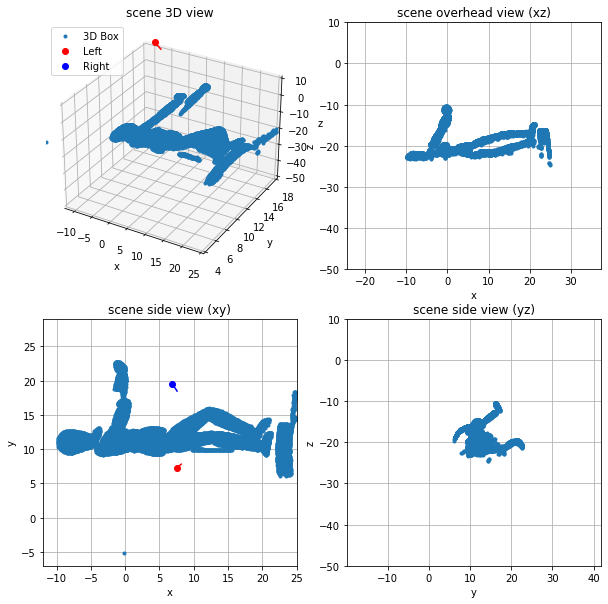

In [452]:
# Add your visualization code here.  As we have done previously it is good to visualize different
# 2D projections XY, XZ, YZ and well as a 3D version

lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,5]]).T))
lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,5]]).T))

# visualize the image of the points in the camera
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

# 3D view (xyz-plane) showing points, camera
# position, and direction camera is pointed
ax = fig.add_subplot(2,2,1,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
ax.set_xlim3d([-12, 25])
ax.set_ylim3d([4, 18])
ax.set_zlim3d([-50, 10])
ax.plot(camL.t[0],camL.t[1],camL.t[2],'ro')
ax.plot(camR.t[0],camR.t[1],camR.t[2],'bo')
ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'r')
ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'b')
plt.title('scene 3D view')
plt.legend(('3D Box','Left','Right'),loc=2)

# overhead view (xz-plane) showing points, camera
# position, and direction camera is pointed
ax = fig.add_subplot(2,2,2)
ax.plot(pts3[0,:],pts3[2,:],'.')
plt.axis('equal')
plt.grid()
ax.set_xlim([-12, 25])
ax.set_ylim([-50, 10])
ax.plot(camL.t[0],camL.t[2],'ro')
ax.plot(lookL[0,:],lookL[2,:],'r')
ax.plot(camR.t[0],camR.t[2],'bo')
ax.plot(lookR[0,:],lookR[2,:],'b')
plt.xlabel('x')
plt.ylabel('z')
plt.title('scene overhead view (xz)')

# overhead view (xY-plane) showing points, camera
# position, and direction camera is pointed
ax = fig.add_subplot(2,2,3)
ax.plot(pts3[0,:],pts3[1,:],'.')
plt.axis('equal')
plt.grid()
ax.set_xlim([-12, 25])
ax.set_ylim([4, 18])
ax.plot(camL.t[0],camL.t[1],'ro')
ax.plot(lookL[0,:],lookL[1,:],'r')
ax.plot(camR.t[0],camR.t[1],'bo')
ax.plot(lookR[0,:],lookR[1,:],'b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('scene side view (xy)')

# side view (yz-plane) showing points, camera
# position, and direction camera is pointed
ax = fig.add_subplot(2,2,4)
ax.plot(pts3[1,:],pts3[2,:],'.')
plt.axis('equal')
plt.grid()
ax.set_xlim([4, 18])
ax.set_ylim([-50, 10])
ax.plot(camL.t[1],camL.t[2],'ro')
ax.plot(lookL[1,:],lookL[2,:],'r')
ax.plot(camR.t[1],camR.t[2],'bo')
ax.plot(lookR[1,:],lookR[2,:],'b')
plt.xlabel('y')
plt.ylabel('z')
plt.title('scene side view (yz)')
plt.show()

In [65]:
def edgeCheck(triangle,thresh):
    """
    Checks if an edge of the triangle is greater than some threshold

    Parameters
    ----------
    triangle : 3x3 numpy.array (dtype=float)
        coordinate points that make up the triangle
        
    thresh : float
        Threshold to determine if an edge is too long
        
    Returns
    -------
    boolean
        true if all edges are less than threshold
        false if at least one edge is greater than threshold
        
    """
    p1,p2,p3 = triangle
    if np.sqrt((p1[0] - p1[1])**2 + (p2[0] - p2[1])**2 + (p3[0] - p3[1])**2) > thresh:
        return False
    if np.sqrt((p1[1] - p1[2])**2 + (p2[1] - p2[2])**2 + (p3[1] - p3[2])**2) > thresh:
        return False
    if np.sqrt((p1[2] - p1[0])**2 + (p2[2] - p2[0])**2 + (p3[2] - p3[0])**2) > thresh:
        return False
    return True

In [457]:
# Mesh cleanup parameters

# Specify limits along the x,y and z axis of a box containing the object
# we will prune out triangulated points outside these limits
boxlimits = np.array([-11,24.25,5,23,-25,-10])

# Specify a longest allowed edge that can appear in the mesh. Remove triangles
# from the final mesh that have edges longer than this value
trithresh = 1.7


#
# bounding box pruning
#
xlims = np.intersect1d(np.argwhere(pts3[0]>boxlimits[0]),np.argwhere(pts3[0]<boxlimits[1]))
ylims = np.intersect1d(np.argwhere(pts3[1]>boxlimits[2]),np.argwhere(pts3[1]<boxlimits[3]))
zlims = np.intersect1d(np.argwhere(pts3[2]>boxlimits[4]),np.argwhere(pts3[2]<boxlimits[5]))
tlims = np.intersect1d(xlims,ylims)
tlims = np.intersect1d(tlims,zlims)
pts3pruned = pts3[:,tlims]
pts2Lpruned = pts2L[:,tlims]
pts2Rpruned = pts2R[:,tlims]

#
# triangulate the 2D points to get the surface mesh
#
# Left Camera
trimL = Delaunay(pts2Lpruned.transpose())
triL = trimL.simplices.copy()
# Right Camera
trimR = Delaunay(pts2Rpruned.transpose())
triR = trimR.simplices.copy()

#
# triangle pruning
#
# Left Camera
goodTriL = []
for i in range(triL.shape[0]):
    if edgeCheck(pts3pruned[:,triL[i]],trithresh):
        goodTriL.append(i)
    

newTriL = triL[goodTriL]

# Right Camera
goodTriR = []
for i in range(triR.shape[0]):
    if edgeCheck(pts3pruned[:,triR[i]],trithresh):
        goodTriR.append(i)

newTriR = triR[goodTriR]


In [458]:
# Mesh smoothing

pts3smoothed = pts3pruned.copy()
for i in range(2):
    for tri in newTriL:
        p1,p2,p3 = pts3smoothed[:,tri].T
        p1new = (p2+p3)/2
        p2new = (p1+p3)/2
        p3new = (p1+p2)/2
        pts3smoothed[:,tri] = np.array([p1new,p2new,p3new]).T

In [461]:
# generate mesh and save it

mesh = trimesh.Trimesh(vertices=pts3smoothed.T,faces=newTriR[:,[0,2,1]])
mesh.export('manmesh1.ply')
mesh.show()